# Monitoring Changes in Surface Water Using Satellite Image Data
## Milestone 1

The deliverable for Milestone 1 is a Jupyter Notebook (preferably hosted on GitHub) showing an example image(s) of a satellite dataset read in using Rasterio, and demonstration of a function that carries out a manipulation of that image using Keras and TensorFlow 2.0. That manipulation could be anything that alters the image, such as its size, geometry (shape), pixel intensities, or spatial projection. This will mostly test your understanding of Keras syntax, which is an essential component of the remaining milestones.

### NOTE
I was unsure what the expected contents of this shoould the included reuses alot of the code from the 
getting started notebook.

With only a few minor changes



## Part 1 
Loading Satellite Image using rasterio

In [1]:
import rasterio
import glob
import os

In [2]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [3]:
file_id = '1o76QoBtn6ExxO8KgcCqdOiun_KsWoMJl'

destination = 'example_TCI_10m.jp2'
download_file_from_google_drive(file_id, destination)

In [4]:
with rasterio.open('example_TCI_10m.jp2', driver='JP2OpenJPEG') as dataset:
    array = dataset.read(1)
    print(dataset.profile)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint8', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 3, 'crs': CRS.from_epsg(32719), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 8000020.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'interleave': 'pixel'}


In [5]:
def write_image(input, output, band):
    with rasterio.open(input) as src_dataset:
        with rasterio.open('example_TCI_10m.jp2', driver='JP2OpenJPEG') as dataset:
            array = dataset.read(band)
        # Get a copy of the source dataset's profile. Thus our
        # destination dataset will have the same dimensions,
        # number of bands, data type, and georeferencing as the
        # source dataset.
        kwds = src_dataset.profile

        # Change the format driver for the destination dataset to
        # 'GTiff', short for GeoTIFF.
        kwds['driver'] = 'GTiff'

        # Add GeoTIFF-specific keyword arguments.
        kwds['tiled'] = True
        kwds['blockxsize'] = 256
        kwds['blockysize'] = 256
        kwds['photometric'] = 'YCbCr'
        kwds['compress'] = 'JPEG'

        with rasterio.open(output, 'w', **kwds) as dst_dataset:
            # Write data to the destination dataset.
            dst_dataset.write(array.astype(rasterio.uint8), 1)

In [6]:
file_list = ['r1.tif', 'r2.tif', 'r3.tif']
[write_image('example_TCI_10m.jp2',f, band) for f,band in zip(file_list, [1,2,3])]

[None, None, None]

In [7]:
# Read metadata of first file
with rasterio.open(file_list[0]) as src0:
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer and write it to stack
with rasterio.open('stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [8]:
[os.remove(f) for f in file_list]

[None, None, None]

In [9]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

# note there is a nested 'with statement' here
# the first 'with' command opens the image as src
with rasterio.open('stack.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
# the second 'with' statement opens an image for writing
    with rasterio.open('reprojected_stack.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

Display Image

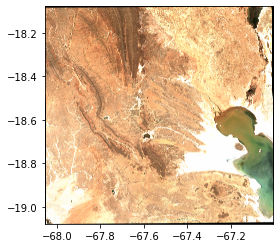

In [10]:
from rasterio.plot import show
src = rasterio.open('reprojected_stack.tif')
show(src.read(), transform=src.transform)
    

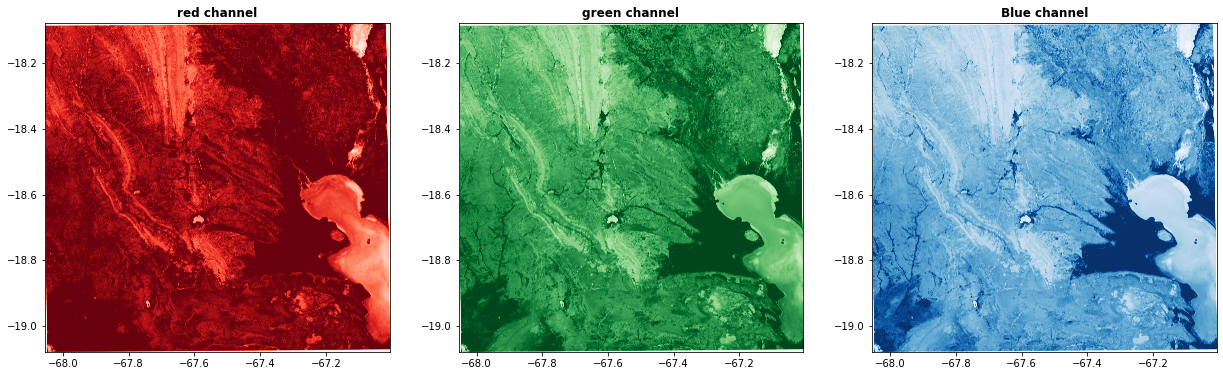

In [11]:
from matplotlib import pyplot
fig, (axr, axg, axb) = pyplot.subplots(1,3, figsize=(21,7))
show((src, 1), ax=axr, cmap='Reds', title='red channel')
show((src, 2), ax=axg, cmap='Greens', title='green channel')
show((src, 3), ax=axb, cmap='Blues', title='Blue channel')    
    

## Part 2
Using Keras for image Manipulation

In [12]:
import tensorflow as tf
tf.__version__


'2.1.0'

In [13]:
# Tensorflow keras layers
from tensorflow.python.keras.layers import Dense, Flatten, Dropout, BatchNormalization

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [14]:
mnist = tf.keras.datasets.mnist

In [15]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
# convert from int to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

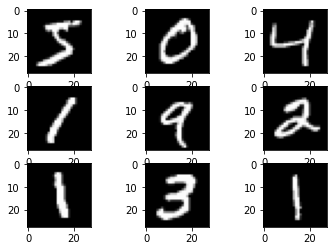

In [16]:
for i in range(0, 9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(X_train[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
# show the plot
pyplot.show()

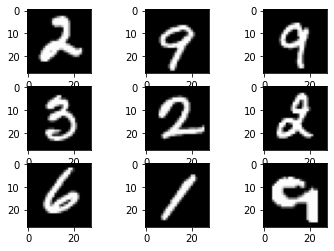

In [17]:
# define data preparation
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break

e:\Anaconda3\envs\lvproject\lib\site-packages\keras_preprocessing\image\image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


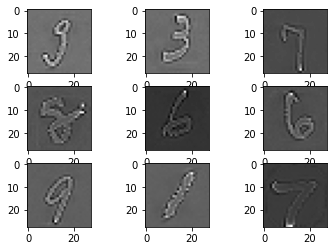

In [18]:
datagen = ImageDataGenerator(zca_whitening=True)
# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break